In [1]:
def calculate_mean_std(df_names, dfs):
    perf_train, perf_fair = [], []

    for df_name, df in zip(df_names, dfs):
        df_train = df[df['data'] == 'train_cont_ord_cat'].drop(columns=['data'])
        df_fair = df[df['data'] == 'fair_cont_ord_cat'].drop(columns=['data'])
        
        df_train_mean = df_train.mean()
        df_train_std = df_train.std()
        #df_train_median = df_train.median()
        df_train_mean['dataset'] = df_name
        df_train_std['dataset'] = df_name
        #df_train_median['dataset'] = df_name
        df_train_mean['type'] = 'mean'
        #df_train_median['type'] = 'median'
        df_train_std['type'] = 'std'
        perf_train.append(df_train_mean.to_frame().T)
        #perf_train.append(df_train_median.to_frame().T)
        perf_train.append(df_train_std.to_frame().T)
        
        df_fair_mean = df_fair.mean()
        #df_fair_median = df_fair.median()
        df_fair_std = df_fair.std()
        df_fair_mean['dataset'] = df_name
        #df_fair_median['dataset'] = df_name
        df_fair_std['dataset'] = df_name
        df_fair_mean['type'] = 'mean'
        #df_fair_median['type'] = 'median'
        df_fair_std['type'] = 'std'
        perf_fair.append(df_fair_mean.to_frame().T)
        #perf_fair.append(df_fair_median.to_frame().T)
        perf_fair.append(df_fair_std.to_frame().T)
    
    perf_train = pd.concat(perf_train).reset_index(drop=True)
    perf_fair = pd.concat(perf_fair).reset_index(drop=True)
    return perf_train, perf_fair

In [2]:
def aggregate_runs(dfs):
    df = pd.concat(dfs).reset_index(drop=True)
    df.drop(columns=['iteration'], inplace=True)
    df = df.groupby(['classifier', 'algorithm']).agg(['mean', 'std'])
    return df

In [3]:
def print_to_latex(dfs):
    df = pd.concat(dfs).reset_index(drop=True)
    df.drop(columns=['iteration'], inplace=True)
    df = df.groupby(['classifier', 'algorithm']).agg(['mean', 'std'])
    print(df.to_latex(index=True))

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

def aggregate_runs_no_mean(dfs, y):
    df = pd.concat(dfs).reset_index(drop=True)
    g = sns.FacetGrid(df, col="classifier")
    g.map_dataframe(sns.lineplot, x='iteration', y=y, hue='algorithm', errorbar=None)
    g.add_legend()
    plt.show()

# Cont ord cat

In [5]:
import os
import pandas as pd

dfs_fairness = []
dfs_performance = []
dataset_names = ['heart_disease', 'german']
classifier_names = ['decision_tree', 'mlp', 'logistic_regression', 'naive_bayes']
algorithm_names = ['new_thing', 'fos', 'hfos', 'fawos', 'fawos_hybrid', 'rbo', 'fair_rbo']
folder_names = ['2024-05-20', '2023-04-27', '2023-04-27', '2023-04-27', '2023-04-27', '2024-05-20', '2024-05-20']

for dataset_name in dataset_names:
    df_data_fair = []
    df_data_perf = []
    for classifier_name in classifier_names:
        for folder_name, algorithm_name in zip(folder_names, algorithm_names):
            for i in range(0, 10):
                if os.path.exists(os.path.join('../results', f'{algorithm_name}_{dataset_name}_{classifier_name}', folder_name, f'fairness_{i}.csv')):
                    fair_path = os.path.join('../results', f'{algorithm_name}_{dataset_name}_{classifier_name}', folder_name, f'fairness_{i}.csv')
                    perf_path = os.path.join('../results', f'{algorithm_name}_{dataset_name}_{classifier_name}', folder_name, f'performance_{i}.csv')
                    df_fair = pd.read_csv(fair_path)
                    df_performance = pd.read_csv(perf_path)
                    df_fair['classifier'] = [classifier_name] * len(df_fair)
                    df_fair['algorithm'] = [algorithm_name if 'fair' in x else '-' for x in df_fair['data']]
                    df_fair['iteration'] = [i] * len(df_fair)
                    # df_fair.drop(columns=['data', 'average_odds', 'average_absolute_odds'], inplace=True)
                    df_fair.drop(columns=['data'], inplace=True)
                    df_performance['classifier'] = [classifier_name] * len(df_performance)
                    df_performance['algorithm'] = [algorithm_name if 'fair' in x else '-' for x in df_performance['data']]
                    df_performance['iteration'] = [i] * len(df_performance)
                    df_performance.drop(columns=['data'], inplace=True)
                    df_data_fair.append(df_fair)
                    df_data_perf.append(df_performance)
    dfs_fairness.append(df_data_fair)
    dfs_performance.append(df_data_perf)
                

In [6]:
for dataset_name, dfs in zip(dataset_names, dfs_fairness):
    df = aggregate_runs(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

heart_disease


statistical_parity            accuracy  \
                                               mean       std      mean   
classifier          algorithm                                             
decision_tree       -                      0.316605  0.174801  0.078657   
                    fair_rbo               0.192143  0.121491  0.048492   
                    fawos                  0.129770  0.117925  0.086454   
                    fawos_hybrid           0.175200  0.200129  0.089754   
                    fos                    0.250322  0.253334  0.066704   
                    hfos                   0.146913  0.201629  0.107664   
                    new_thing              0.153800  0.201546  0.071907   
                    rbo                    0.350088  0.186848  0.090771   
logistic_regression -                      0.315931  0.154675  0.071508   
                    fair_rbo               0.198730  0.190628  0.054603   
                    fawos                  0.189507  0.192902  0.107365   
                    fawos_hybrid           0.198454  0.169751  0.073961   
                    fos                    0.326918  0.183298  0.097016   
                    hfos                   0.171854  0.242791  0.046626   
                    new_thing              0.188786  0.188970  0.055598   
                    rbo                    0.337403  0.156470  0.074071   
mlp                 -                      0.096457  0.172558  0.076346   
                    fair_rbo               0.115794  0.130454  0.068016   
                    fawos                  0.006242  0.211634  0.218294   
                    fawos_hybrid           0.037942  0.204449  0.103662   
                    fos                    0.101463  0.177541 -0.043868   
                    hfos                   0.054695  0.173107  0.048778   
                    new_thing              0.038390  0.169966  0.006858   
                    rbo                    0.081059  0.205824  0.005725   
naive_bayes         -                      0.272858  0.160986  0.110325   
                    fair_rbo               0.158968  0.144189  0.084365   
                    fawos                  0.168160  0.175017  0.141094   
                    fawos_hybrid           0.192402  0.171468  0.107044   
                    fos                    0.233007  0.169153  0.091725   
                    hfos                   0.203909  0.160526  0.139350   
                    new_thing              0.118687  0.169718  0.069720   
                    rbo                    0.082263  0.177541  0.234192   

                                           equal_opportunity            \
                                       std              mean       std   
classifier          algorithm                                            
decision_tree       -             0.104697         -0.180483  0.156001   
                    fair_rbo      0.182209         -0.025198  0.175568   
                    fawos         0.214903          0.035794  0.107967   
                    fawos_hybrid  0.093506         -0.100650  0.161204   
                    fos           0.140651         -0.148355  0.334694   
                    hfos          0.189123         -0.054700  0.264291   
                    new_thing     0.137090         -0.030911  0.200335   
                    rbo           0.102482         -0.238841  0.240025   
logistic_regression -             0.096011         -0.149426  0.166430   
                    fair_rbo      0.123174         -0.045635  0.207594   
                    fawos         0.110573         -0.056691  0.126861   
                    fawos_hybrid  0.113575         -0.070097  0.151705   
                    fos           0.138338         -0.268600  0.221494   
                    hfos          0.159324         -0.010249  0.274920   
                    new_thing     0.104379         -0.047839  0.150970   
                    rbo           0.084907         -0.181728  0.182448   
m

----------------------------------------------------------------
german


statistical_parity            accuracy  \
                                               mean       std      mean   
classifier          algorithm                                             
decision_tree       -                      0.016897  0.097647  0.049502   
                    fawos                  0.027926  0.090736  0.039121   
                    fawos_hybrid          -0.012076  0.119401  0.016249   
                    fos                    0.029079  0.145528  0.034582   
                    hfos                   0.129441  0.145374  0.042364   
                    new_thing              0.042816  0.128232  0.023722   
                    rbo                    0.246809  0.108875  0.110338   
logistic_regression -                      0.089208  0.098672  0.012261   
                    fawos                  0.002442  0.097133  0.026080   
                    fawos_hybrid           0.033161  0.107285 -0.007268   
                    fos                    0.048897  0.129332 -0.007955   
                    hfos                  -0.086075  0.125804 -0.037281   
                    new_thing             -0.040079  0.092846 -0.068005   
                    rbo                    0.084268  0.127191  0.109096   
mlp                 -                      0.067666  0.064314  0.071851   
                    fawos                  0.020885  0.059128  0.057051   
                    fawos_hybrid           0.071483  0.128259  0.026626   
                    fos                    0.073455  0.117644  0.024061   
                    hfos                  -0.073715  0.117444 -0.009913   
                    new_thing             -0.007939  0.080354 -0.043099   
                    rbo                    0.176944  0.098377  0.077438   
naive_bayes         -                      0.098874  0.098967  0.025924   
                    fawos                  0.040438  0.101892  0.018119   
                    fawos_hybrid           0.049941  0.105116 -0.015261   
                    fos                    0.049242  0.097550 -0.002259   
                    hfos                   0.066240  0.126436  0.027041   
                    new_thing              0.046639  0.074502  0.002557   
                    rbo                    0.230440  0.078454  0.087471   

                                           equal_opportunity            \
                                       std              mean       std   
classifier          algorithm                                            
decision_tree       -             0.059400         -0.012655  0.060575   
                    fawos         0.086939         -0.010396  0.069696   
                    fawos_hybrid  0.091798          0.010948  0.109414   
                    fos           0.116238         -0.022969  0.158476   
                    hfos          0.127993         -0.102624  0.178902   
                    new_thing     0.124224         -0.029486  0.161919   
                    rbo           0.085094         -0.226893  0.106525   
logistic_regression -             0.053927         -0.035888  0.067109   
                    fawos         0.077671          0.018422  0.065379   
                    fawos_hybrid  0.083021          0.002749  0.102275   
                    fos           0.077798         -0.006030  0.105687   
                    hfos          0.071452          0.121038  0.075503   
                    new_thing     0.081201          0.099905  0.100598   
                    rbo           0.099940         -0.100312  0.152251   
mlp                 -             0.079968         -0.062180  0.077498   
                    fawos         0.050536         -0.013275  0.050825   
                    fawos_hybrid  0.103481         -0.046083  0.122525   
                    fos           0.049485         -0.047304  0.093284   
                    hfos          0.101098          0.092508  0.111427   
                    new_thing     0.105736          0.057293  0.118075   
     

----------------------------------------------------------------


In [17]:
for dataset_name, dfs in zip(dataset_names, dfs_fairness):
    print(dataset_name)
    print_to_latex(dfs)
    print('----------------------------------------------------------------')

german
\begin{tabular}{llrrrrrrrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{statistical_parity} & \multicolumn{2}{r}{equal_opportunity} & \multicolumn{2}{r}{average_odds} & \multicolumn{2}{r}{average_absolute_odds} & \multicolumn{2}{r}{disparate_impact} & \multicolumn{2}{r}{adapted_disparate_impact} \\
 &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
classifier & algorithm &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{decision_tree} & - & 0.016897 & 0.099346 & -0.012655 & 0.061629 & -0.004673 & 0.129591 & 0.108652 & 0.076055 & 0.981596 & 0.121612 & 0.915048 & 0.082637 \\
 & fos & 0.029079 & 0.145528 & -0.022969 & 0.158476 & 0.012973 & 0.163302 & 0.139046 & 0.098991 & 0.981664 & 0.230877 & 0.828046 & 0.109433 \\
 & new_thing & 0.049857 & 0.144445 & -0.066970 & 0.149854 & 0.025199 & 0.159625 & 0.146165 & 0.085661 & 0.913826 & 0.239176 & 0.804223 & 0.136026 \\
\cline{1-14}
\multirow[t]{3}{*}{logistic_regression} & - & 0.089208 & 0.1003

In [7]:
for dataset_name, dfs in zip(dataset_names, dfs_performance):
    df = aggregate_runs(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

heart_disease


accuracy           balanced_accuracy  \
                                      mean       std              mean   
classifier          algorithm                                            
decision_tree       -             0.797865  0.065762          0.795977   
                    fair_rbo      0.780690  0.074623          0.773931   
                    fawos         0.755172  0.094527          0.734215   
                    fawos_hybrid  0.733678  0.089339          0.727086   
                    fos           0.744023  0.102744          0.745341   
                    hfos          0.770805  0.059702          0.762219   
                    new_thing     0.764483  0.082607          0.749924   
                    rbo           0.801724  0.068953          0.795589   
logistic_regression -             0.841823  0.064643          0.835204   
                    fair_rbo      0.787931  0.061241          0.784000   
                    fawos         0.808391  0.053845          0.796720   
                    fawos_hybrid  0.808276  0.056195          0.795802   
                    fos           0.801494  0.061818          0.803058   
                    hfos          0.807931  0.074522          0.793236   
                    new_thing     0.811724  0.060594          0.805608   
                    rbo           0.838391  0.068107          0.832591   
mlp                 -             0.761658  0.069208          0.743743   
                    fair_rbo      0.757701  0.076419          0.749058   
                    fawos         0.700920  0.108840          0.682773   
                    fawos_hybrid  0.751264  0.084014          0.732779   
                    fos           0.757471  0.100065          0.763009   
                    hfos          0.774713  0.081009          0.760247   
                    new_thing     0.784483  0.061604          0.774775   
                    rbo           0.767701  0.093635          0.765567   
naive_bayes         -             0.833530  0.053757          0.827588   
                    fair_rbo      0.787701  0.050971          0.783116   
                    fawos         0.787931  0.049986          0.772650   
                    fawos_hybrid  0.824943  0.056521          0.812731   
                    fos           0.831379  0.059741          0.823699   
                    hfos          0.814828  0.053281          0.798752   
                    new_thing     0.794943  0.056923          0.779999   
                    rbo           0.697701  0.083842          0.671876   

                                                  f1               gmean  \
                                       std      mean       std      mean   
classifier          algorithm                                              
decision_tree       -             0.071858  0.771152  0.081699  0.793696   
                    fair_rbo      0.075608  0.745145  0.097216  0.765862   
                    fawos         0.098897  0.653559  0.166785  0.697593   
                    fawos_hybrid  0.092336  0.685930  0.118563  0.723414   
                    fos           0.101788  0.729788  0.118813  0.741440   
                    hfos          0.064760  0.722070  0.102182  0.756362   
                    new_thing     0.089785  0.712260  0.120173  0.741354   
                    rbo           0.081947  0.782517  0.069153  0.791835   
logistic_regression -             0.066528  0.818635  0.066924  0.831928   
                    fair_rbo      0.058971  0.765962  0.060928  0.779243   
                    fawos         0.053172  0.756099  0.074875  0.785166   
                    fawos_hybrid  0.070618  0.774637  0.078415  0.789169   
                    fos           0.068325  0.791129  0.079174  0.799732   
                    hfos          0.087671  0.779379  0.101077  0.787365   
                    new_thing     0.068196  0.777286  0.091447  0.802022   
                    rbo           0.073301  0.819156  0.067626  0.829873   

----------------------------------------------------------------
german


accuracy           balanced_accuracy  \
                                     mean       std              mean   
classifier          algorithm                                           
decision_tree       -               0.719  0.051312          0.626486   
                    fawos           0.707  0.046916          0.604427   
                    fawos_hybrid    0.644  0.049933          0.640696   
                    fos             0.648  0.035839          0.625054   
                    hfos            0.693  0.059264          0.667499   
                    new_thing       0.642  0.057504          0.624841   
                    rbo             0.661  0.043830          0.553393   
logistic_regression -               0.733  0.045110          0.630921   
                    fawos           0.730  0.050332          0.613759   
                    fawos_hybrid    0.699  0.046296          0.673828   
                    fos             0.686  0.049035          0.670454   
                    hfos            0.718  0.058652          0.667421   
                    new_thing       0.692  0.041580          0.686893   
                    rbo             0.669  0.057048          0.494902   
mlp                 -               0.709  0.042414          0.562660   
                    fawos           0.709  0.037550          0.549472   
                    fawos_hybrid    0.708  0.046857          0.681542   
                    fos             0.686  0.046476          0.662896   
                    hfos            0.716  0.038064          0.659293   
                    new_thing       0.681  0.053635          0.666362   
                    rbo             0.686  0.047188          0.542571   
naive_bayes         -               0.664  0.084155          0.637905   
                    fawos           0.668  0.094493          0.630888   
                    fawos_hybrid    0.639  0.102572          0.626341   
                    fos             0.558  0.062325          0.615296   
                    hfos            0.627  0.090068          0.638821   
                    new_thing       0.625  0.082496          0.647236   
                    rbo             0.598  0.065794          0.543309   

                                                  f1               gmean  \
                                       std      mean       std      mean   
classifier          algorithm                                              
decision_tree       -             0.057173  0.809864  0.039529  0.576084   
                    fawos         0.035430  0.803767  0.039407  0.542958   
                    fawos_hybrid  0.061658  0.714799  0.053895  0.635208   
                    fos           0.054149  0.729350  0.034326  0.618464   
                    hfos          0.069839  0.770111  0.048277  0.658052   
                    new_thing     0.065734  0.721713  0.053050  0.621490   
                    rbo           0.043682  0.772382  0.037487  0.472287   
logistic_regression -             0.059854  0.822510  0.031781  0.571774   
                    fawos         0.049349  0.823350  0.036821  0.538280   
                    fawos_hybrid  0.065923  0.773088  0.034726  0.666886   
                    fos           0.070591  0.759743  0.033592  0.665586   
                    hfos          0.068908  0.797024  0.044215  0.652227   
                    new_thing     0.059651  0.760704  0.036219  0.683571   
                    rbo           0.010357  0.795202  0.048624  0.127054   
mlp                 -             0.026436  0.815436  0.034137  0.420476   
                    fawos         0.036365  0.819119  0.028944  0.349109   
                    fawos_hybrid  0.064149  0.781084  0.034902  0.675765   
                    fos           0.070897  0.762097  0.032530  0.656887   
                    hfos          0.046147  0.796860  0.032257  0.642217   
                    new_thing     0.070827  0.754342  0.045989  0.662172   
                    r

----------------------------------------------------------------


In [19]:
for dataset_name, dfs in zip(dataset_names, dfs_performance):
    print(dataset_name)
    print_to_latex(dfs)
    print('----------------------------------------------------------------')

german
\begin{tabular}{llrrrrrrrr}
\toprule
 &  & \multicolumn{2}{r}{accuracy} & \multicolumn{2}{r}{balanced_accuracy} & \multicolumn{2}{r}{f1} & \multicolumn{2}{r}{gmean} \\
 &  & mean & std & mean & std & mean & std & mean & std \\
classifier & algorithm &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{decision_tree} & - & 0.719000 & 0.052204 & 0.626486 & 0.058168 & 0.809864 & 0.040217 & 0.576084 & 0.083008 \\
 & fos & 0.648000 & 0.035839 & 0.625054 & 0.054149 & 0.729350 & 0.034326 & 0.618464 & 0.058875 \\
 & new_thing & 0.621000 & 0.064196 & 0.594747 & 0.071259 & 0.707942 & 0.060920 & 0.583443 & 0.078822 \\
\cline{1-10}
\multirow[t]{3}{*}{logistic_regression} & - & 0.733000 & 0.045895 & 0.630921 & 0.060895 & 0.822510 & 0.032334 & 0.571774 & 0.084368 \\
 & fos & 0.686000 & 0.049035 & 0.670454 & 0.070591 & 0.759743 & 0.033592 & 0.665586 & 0.074350 \\
 & new_thing & 0.685000 & 0.045522 & 0.658758 & 0.058508 & 0.762606 & 0.034764 & 0.652819 & 0.063392 \\
\cline{1-10}
\multirow[t]{

heart_disease


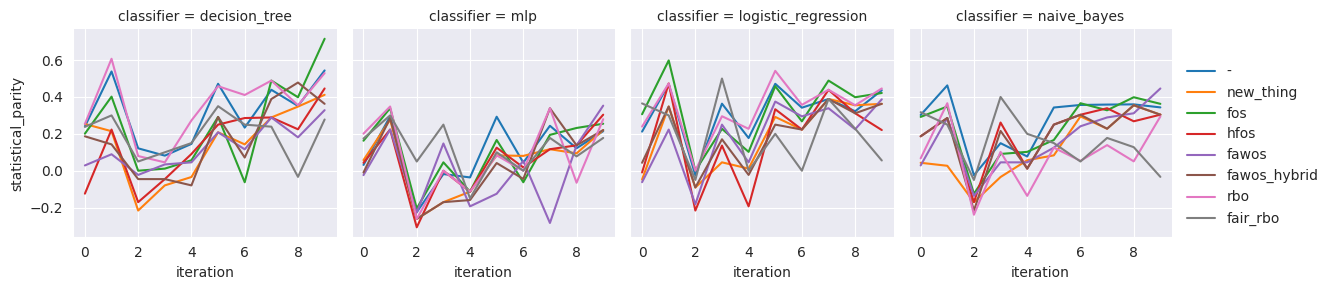

german


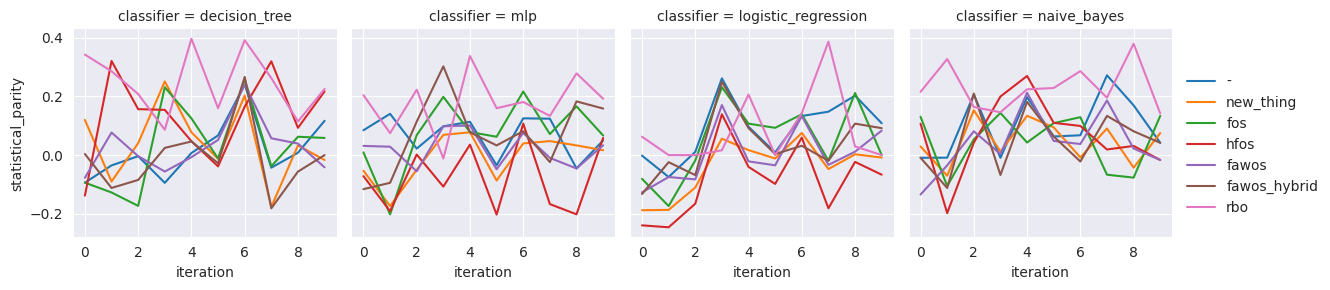

In [8]:
for dataset_name, dfs in zip(dataset_names, dfs_fairness):
    print(dataset_name)
    aggregate_runs_no_mean(dfs, y='statistical_parity')

german


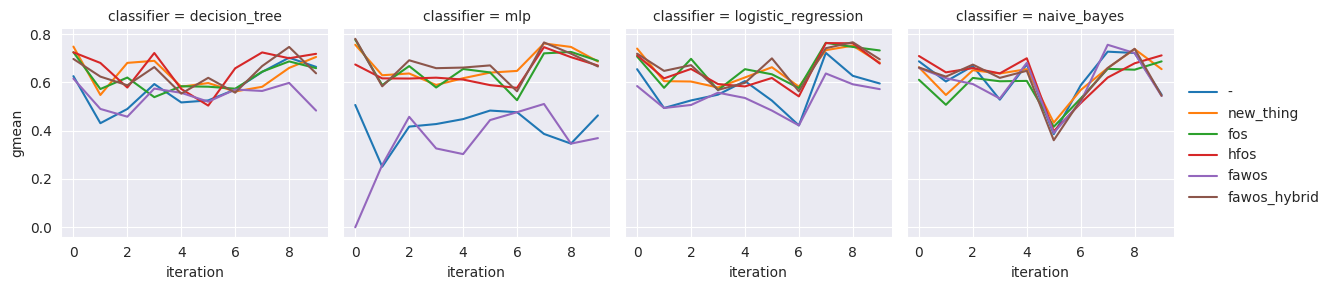

heart_disease


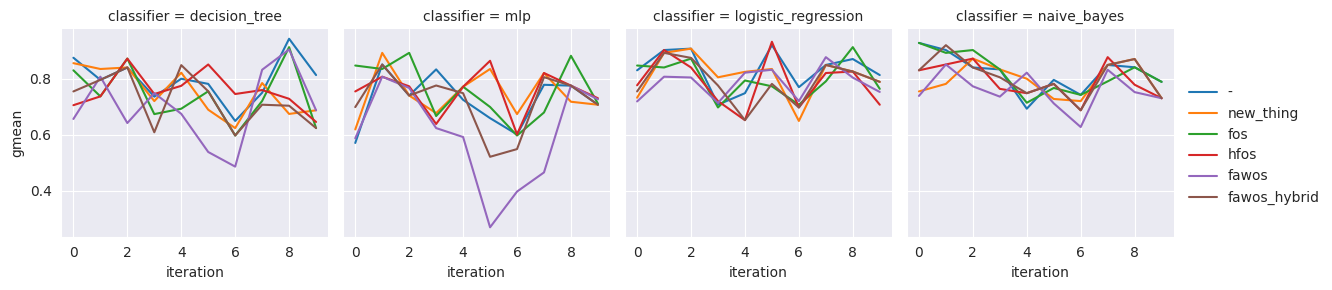

In [20]:
for dataset_name, dfs in zip(dataset_names, dfs_performance):
    print(dataset_name)
    aggregate_runs_no_mean(dfs, y='gmean')

# Cont 

In [26]:
dfs_fairness = []
dfs_performance = []
dataset_names = ['adult', 'german', 'heart_disease']
classifier_names = ['decision_tree', 'mlp', 'logistic_regression', 'naive_bayes']
algorithm_names = ['fos', 'hfos']
folder_names = ['2023-04-26-cont', '2023-04-26-cont']

for dataset_name in dataset_names:
    df_data_fair = []
    df_data_perf = []
    for classifier_name in classifier_names:
        for folder_name, algorithm_name in zip(folder_names, algorithm_names):
            for i in range(0, 6):
                if os.path.exists(os.path.join('../results/results', f'{algorithm_name}_{dataset_name}_{classifier_name}', folder_name, f'fairness_{i}.csv')):
                    fair_path = os.path.join('../results/results', f'{algorithm_name}_{dataset_name}_{classifier_name}', folder_name, f'fairness_{i}.csv')
                    perf_path = os.path.join('../results/results', f'{algorithm_name}_{dataset_name}_{classifier_name}', folder_name, f'performance_{i}.csv')
                    df_fair = pd.read_csv(fair_path)
                    df_performance = pd.read_csv(perf_path)
                    df_fair['classifier'] = [classifier_name] * len(df_fair)
                    df_fair['algorithm'] = [algorithm_name if 'fair' in x else '-' for x in df_fair['data']]
                    df_fair['iteration'] = [i] * len(df_fair)
                    df_fair.drop(columns=['data', 'average_odds', 'average_absolute_odds'], inplace=True)
                    df_performance['classifier'] = [classifier_name] * len(df_performance)
                    df_performance['algorithm'] = [algorithm_name if 'fair' in x else '-' for x in df_performance['data']]
                    df_performance['iteration'] = [i] * len(df_performance)
                    df_performance.drop(columns=['data'], inplace=True)
                    df_data_fair.append(df_fair)
                    df_data_perf.append(df_performance)
    dfs_fairness.append(df_data_fair)
    dfs_performance.append(df_data_perf)

In [27]:
for dataset_name, dfs in zip(dataset_names, dfs_fairness):
    df = aggregate_runs(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

adult


statistical_parity                      \
                                            mean    median       std   
classifier          algorithm                                          
decision_tree       -                   0.125269  0.120176  0.021182   
                    fos                 0.121753  0.127291  0.026533   
                    hfos                0.016040  0.019932  0.111692   
logistic_regression -                   0.147487  0.145807  0.016657   
                    fos                 0.055304  0.050247  0.021010   
                    hfos                0.079917  0.071232  0.023364   
mlp                 -                   0.153106  0.154085  0.013379   
                    fos                 0.041748  0.038077  0.035566   
                    hfos                0.052041  0.063387  0.044011   
naive_bayes         -                   0.133718  0.136344  0.006218   
                    fos                 0.117503  0.115197  0.018323   
                    hfos                0.135519  0.131212  0.018937   

                              equal_opportunity                      \
                                           mean    median       std   
classifier          algorithm                                         
decision_tree       -                 -0.112865 -0.095844  0.064838   
                    fos               -0.041532 -0.044712  0.046265   
                    hfos               0.055629  0.064256  0.129961   
logistic_regression -                 -0.153853 -0.147858  0.029107   
                    fos                0.032577  0.018346  0.038241   
                    hfos               0.010822  0.005199  0.018328   
mlp                 -                 -0.172555 -0.157334  0.063081   
                    fos                0.043609  0.021590  0.058427   
                    hfos               0.030110  0.019342  0.069106   
naive_bayes         -                 -0.159806 -0.151687  0.029754   
                    fos               -0.102658 -0.096681  0.029935   
                    hfos              -0.131164 -0.127065  0.020570   

                              disparate_impact                      \
                                          mean    median       std   
classifier          algorithm                                        
decision_tree       -                 0.556352  0.572761  0.068754   
                    fos               0.681813  0.667788  0.061058   
                    hfos              1.000730  0.965974  0.316074   
logistic_regression -                 0.430997  0.423869  0.048567   
                    fos               0.856665  0.869872  0.051113   
                    hfos              0.797155  0.817200  0.053656   
mlp                 -                 0.435854  0.451452  0.046326   
                    fos               0.894247  0.902489  0.086150   
                    hfos              0.868138  0.843417  0.110265   
naive_bayes         -                 0.410850  0.411554  0.024246   
                    fos               0.539436  0.550067  0.063933   
                    hfos              0.502426  0.511415  0.053157   

                              adapted_disparate_impact                      
                                                  mean    median       std  
classifier          algorithm                                               
decision_tree       -                         0.556352  0.572761  0.068754  
                    fos                       0.681813  0.667788  0.061058  
                    hfos                      0.755214  0.744069  0.070601  
logistic_regression -                         0.430997  0.423869  0.048567  
                    fos                       0.856665  0.869872  0.051113  
                    hfos                      0.797155  0.817200  0.053656  
mlp                 -                         0.435854  0.451452  0.046326  
                    fos                       0.886828  0.9024

----------------------------------------------------------------
german


statistical_parity                      \
                                            mean    median       std   
classifier          algorithm                                          
decision_tree       -                   0.011778  0.006761  0.054035   
                    fos                 0.004706 -0.084440  0.177481   
                    hfos                0.021551  0.022663  0.025824   
logistic_regression -                   0.054747  0.045639  0.039408   
                    fos                 0.251554  0.251515  0.066717   
                    hfos                0.042821  0.004920  0.066299   
mlp                 -                   0.046250  0.054124  0.050063   
                    fos                 0.175952  0.179439  0.099534   
                    hfos                0.012750 -0.011642  0.087291   
naive_bayes         -                   0.095536  0.083640  0.069651   
                    fos                 0.184410  0.162476  0.135797   
                    hfos                0.020478 -0.022941  0.122837   

                              equal_opportunity                      \
                                           mean    median       std   
classifier          algorithm                                         
decision_tree       -                  0.002445  0.015641  0.061736   
                    fos               -0.008505  0.028352  0.167540   
                    hfos              -0.017724 -0.007188  0.042252   
logistic_regression -                 -0.004530 -0.006108  0.055253   
                    fos               -0.239768 -0.265870  0.096324   
                    hfos              -0.019211  0.000259  0.082313   
mlp                 -                 -0.003799 -0.043957  0.069609   
                    fos               -0.172750 -0.143380  0.136559   
                    hfos               0.023055  0.048462  0.135330   
naive_bayes         -                 -0.040910 -0.050212  0.063623   
                    fos               -0.185978 -0.200653  0.113306   
                    hfos              -0.002316 -0.010390  0.116525   

                              disparate_impact                      \
                                          mean    median       std   
classifier          algorithm                                        
decision_tree       -                 0.986976  0.991371  0.064336   
                    fos               0.996984  1.126598  0.271177   
                    hfos              0.965016  0.965832  0.041720   
logistic_regression -                 0.940656  0.950315  0.041254   
                    fos               0.618007  0.615773  0.081921   
                    hfos              0.929274  0.991286  0.107506   
mlp                 -                 0.951660  0.943439  0.055150   
                    fos               0.732381  0.729094  0.140504   
                    hfos              0.987628  1.019338  0.142296   
naive_bayes         -                 0.885300  0.899496  0.081762   
                    fos               0.736583  0.752276  0.175031   
                    hfos              0.976957  1.034818  0.187560   

                              adapted_disparate_impact                      
                                                  mean    median       std  
classifier          algorithm                                               
decision_tree       -                         0.957929  0.983364  0.047420  
                    fos                       0.787715  0.824338  0.110657  
                    hfos                      0.959102  0.965832  0.034663  
logistic_regression -                         0.940656  0.950315  0.041254  
                    fos                       0.618007  0.615773  0.081921  
                    hfos                      0.925662  0.989127  0.104539  
mlp                 -                         0.934477  0.938386  0.029281  
                    fos                       0.732381  0.7290

----------------------------------------------------------------
heart_disease


statistical_parity                      \
                                            mean    median       std   
classifier          algorithm                                          
decision_tree       -                   0.266482  0.263258  0.142662   
                    fos                 0.311716  0.234726  0.202950   
                    hfos                0.157021  0.177655  0.176721   
logistic_regression -                   0.346813  0.309500  0.117496   
                    fos                 0.436232  0.414134  0.204966   
                    hfos                0.187477  0.168226  0.156641   
mlp                 -                   0.256052  0.261682  0.104004   
                    fos                 0.189959  0.282708  0.178847   
                    hfos               -0.009461 -0.008007  0.077007   
naive_bayes         -                   0.314722  0.274632  0.159167   
                    fos                 0.254558  0.216074  0.163812   
                    hfos                0.127716  0.093939  0.152395   

                              equal_opportunity                      \
                                           mean    median       std   
classifier          algorithm                                         
decision_tree       -                 -0.066089 -0.133333  0.217511   
                    fos               -0.131171 -0.084936  0.220061   
                    hfos              -0.036292 -0.106250  0.230173   
logistic_regression -                 -0.156420 -0.191667  0.141011   
                    fos               -0.284806 -0.181891  0.233702   
                    hfos              -0.041143  0.025397  0.159253   
mlp                 -                 -0.094999 -0.083868  0.095046   
                    fos               -0.053884 -0.111806  0.111228   
                    hfos               0.162508  0.158494  0.099703   
naive_bayes         -                 -0.161513 -0.162500  0.208438   
                    fos               -0.092300 -0.047596  0.237161   
                    hfos               0.026539  0.028632  0.174604   

                              disparate_impact                      \
                                          mean    median       std   
classifier          algorithm                                        
decision_tree       -                 0.648195  0.617080  0.160328   
                    fos               0.559029  0.654115  0.204226   
                    hfos              0.811133  0.744061  0.283708   
logistic_regression -                 0.574206  0.586294  0.101099   
                    fos               0.441369  0.495596  0.194935   
                    hfos              0.762138  0.761708  0.187875   
mlp                 -                 0.702833  0.684028  0.129618   
                    fos               0.739052  0.603560  0.276228   
                    hfos              1.023431  1.009427  0.158670   
naive_bayes         -                 0.615654  0.676867  0.151675   
                    fos               0.654555  0.717053  0.180238   
                    hfos              0.851118  0.862664  0.232104   

                              adapted_disparate_impact                      
                                                  mean    median       std  
classifier          algorithm                                               
decision_tree       -                         0.648195  0.617080  0.160328  
                    fos                       0.559029  0.654115  0.204226  
                    hfos                      0.732353  0.698489  0.179233  
logistic_regression -                         0.574206  0.586294  0.101099  
                    fos                       0.441369  0.495596  0.194935  
                    hfos                      0.758454  0.761708  0.182147  
mlp                 -                         0.702833  0.684028  0.129618  
                    fos                       0.686574  0.6035

----------------------------------------------------------------


In [30]:
for dataset_name, dfs in zip(dataset_names, dfs_performance):
    df = aggregate_runs(dfs)
    print(dataset_name)
    display(df)
    print('----------------------------------------------------------------')

adult


accuracy                     balanced_accuracy  \
                                   mean    median       std              mean   
classifier          algorithm                                                   
decision_tree       -          0.833560  0.834619  0.007204          0.782639   
                    fos        0.791287  0.792189  0.010517          0.776908   
                    hfos       0.778992  0.778635  0.011691          0.761489   
logistic_regression -          0.813469  0.812681  0.008871          0.747219   
                    fos        0.780760  0.779412  0.006937          0.771635   
                    hfos       0.779715  0.777912  0.005192          0.771865   
mlp                 -          0.815719  0.813163  0.007593          0.754805   
                    fos        0.781081  0.781099  0.010388          0.774741   
                    hfos       0.783973  0.788332  0.013655          0.779139   
naive_bayes         -          0.810576  0.808582  0.007676          0.731056   
                    fos        0.814111  0.813886  0.008591          0.748780   
                    hfos       0.811137  0.812199  0.011758          0.751234   

                                                         f1            \
                                 median       std      mean    median   
classifier          algorithm                                           
decision_tree       -          0.784197  0.004826  0.708021  0.710911   
                    fos        0.777722  0.005484  0.688277  0.689063   
                    hfos       0.758588  0.010939  0.668454  0.666214   
logistic_regression -          0.746890  0.008233  0.656183  0.655609   
                    fos        0.770729  0.005276  0.679987  0.679667   
                    hfos       0.771092  0.004732  0.679948  0.678752   
mlp                 -          0.755635  0.007678  0.667311  0.670592   
                    fos        0.777933  0.008313  0.683401  0.685933   
                    hfos       0.779144  0.010616  0.688644  0.686019   
naive_bayes         -          0.733650  0.005560  0.631087  0.634068   
                    fos        0.748188  0.006860  0.658575  0.658415   
                    hfos       0.755406  0.010696  0.661536  0.666434   

                                            gmean                      
                                    std      mean    median       std  
classifier          algorithm                                          
decision_tree       -          0.007083  0.770807  0.771892  0.004887  
                    fos        0.008321  0.775812  0.776696  0.005254  
                    hfos       0.014731  0.759202  0.756670  0.012742  
logistic_regression -          0.011042  0.726068  0.726811  0.010536  
                    fos        0.003721  0.771195  0.770079  0.005276  
                    hfos       0.005283  0.771547  0.770715  0.004778  
mlp                 -          0.010874  0.737210  0.739336  0.009476  
                    fos        0.011521  0.774493  0.777815  0.008202  
                    hfos       0.014839  0.778928  0.778666  0.010556  
naive_bayes         -          0.008388  0.699778  0.702810  0.008574  
                    fos        0.009289  0.728292  0.727373  0.008577  
                    hfos       0.015149  0.734078  0.738403  0.011969

----------------------------------------------------------------


# HFOS

In [2]:
import pandas as pd

df_adult_fair = pd.read_csv('../results/hfos_adult_lr/fairness_only_cont_int_5.csv')
df_adult_perf = pd.read_csv("../results/hfos_adult_lr/performance_only_cont_int_5.csv")

df_german_fair = pd.read_csv('../results/hfos_german_lr/fairness_only_cont_int_5.csv')
df_german_perf = pd.read_csv("../results/hfos_german_lr/performance_only_cont_int_5.csv")

df_bank_fair = pd.read_csv('../results/hfos_bank_lr/fairness_only_cont_int_5.csv')
df_bank_perf = pd.read_csv("../results/hfos_bank_lr/performance_only_cont_int_5.csv")

In [3]:
perf_train, perf_fair = calculate_mean_std(['adult', 'german', 'bank'], [df_adult_perf, df_german_perf, df_bank_perf])

In [4]:
perf_train

,accuracy,balanced_accuracy,f1,gmean,dataset,type
0,0.844732,0.762898,0.658594,0.745067,adult,mean
1,0.843798,0.762012,0.658555,0.743291,adult,median
2,0.003477,0.003949,0.004621,0.005682,adult,std
3,0.727143,0.624989,0.818232,0.570086,german,mean
4,0.74,0.63156,0.827815,0.577214,german,median
5,0.027667,0.016897,0.023679,0.022371,german,std
6,0.900857,0.646407,0.424949,0.554594,bank,mean
7,0.90239,0.646318,0.423395,0.555497,bank,median
8,0.004095,0.008984,0.01928,0.015577,bank,std


In [5]:
perf_fair

,accuracy,balanced_accuracy,f1,gmean,dataset,type
0,0.816274,0.770599,0.647913,0.763797,adult,mean
1,0.819886,0.769126,0.652506,0.762179,adult,median
2,0.007815,0.022136,0.025453,0.027609,adult,std
3,0.684286,0.641737,0.768487,0.631191,german,mean
4,0.7,0.652376,0.776978,0.632306,german,median
5,0.04097,0.04403,0.03494,0.047648,german,std
6,0.807152,0.733495,0.438007,0.724272,bank,mean
7,0.822488,0.747121,0.452916,0.734867,bank,median
8,0.04204,0.031528,0.041257,0.041032,bank,std


In [6]:
fair_train, fair_fair = calculate_mean_std(['adult', 'german', 'bank'], [df_adult_fair, df_german_fair, df_bank_fair])

In [7]:
fair_train

,statistical_parity,equal_opportunity,average_odds,average_absolute_odds,disparate_impact,adapted_disparate_impact,dataset,type
0,0.105636,-0.080736,0.061109,0.061109,0.523412,0.523412,adult,mean
1,0.106311,-0.08253,0.060943,0.060943,0.512991,0.512991,adult,median
2,0.010173,0.032679,0.015775,0.015775,0.038465,0.038465,adult,std
3,0.069782,-0.051006,0.053745,0.090434,0.915191,0.891301,german,mean
4,0.088093,-0.050691,0.082846,0.085362,0.890501,0.890501,german,median
5,0.082565,0.073148,0.097169,0.057229,0.100041,0.067565,german,std
6,0.112382,-0.126814,0.089317,0.089317,0.330847,0.330847,bank,mean
7,0.122251,-0.133342,0.09544,0.09544,0.311355,0.311355,bank,median
8,0.022144,0.068876,0.038038,0.038038,0.059947,0.059947,bank,std


In [8]:
fair_fair

,statistical_parity,equal_opportunity,average_odds,average_absolute_odds,disparate_impact,adapted_disparate_impact,dataset,type
0,-0.023203,0.1575,-0.112846,0.149007,1.173751,0.719806,adult,mean
1,-0.007042,0.14391,-0.103472,0.114527,1.023997,0.742043,adult,median
2,0.127968,0.171817,0.137942,0.090349,0.519963,0.208151,adult,std
3,0.130876,-0.121212,0.107342,0.221797,0.835658,0.722084,german,mean
4,0.154416,-0.134386,0.124658,0.222688,0.776768,0.757576,german,median
5,0.244426,0.202711,0.251851,0.142052,0.329468,0.205908,german,std
6,0.285128,-0.168256,0.203018,0.203018,0.487265,0.487265,bank,mean
7,0.235401,-0.100962,0.164811,0.164811,0.544632,0.544632,bank,median
8,0.224469,0.168464,0.209667,0.209667,0.169916,0.169916,bank,std


# FAWOS

In [9]:
df_german_fair = pd.read_csv('../results/fawos_german_lr/fairness_5.csv')
df_german_perf = pd.read_csv("../results/fawos_german_lr/performance_5.csv")

In [10]:
perf_train, perf_fair = calculate_mean_std(['german'], [df_bank_perf])

In [11]:
perf_train

,accuracy,balanced_accuracy,f1,gmean,dataset,type
0,0.900857,0.646407,0.424949,0.554594,german,mean
1,0.90239,0.646318,0.423395,0.555497,german,median
2,0.004095,0.008984,0.01928,0.015577,german,std


In [12]:
perf_fair

,accuracy,balanced_accuracy,f1,gmean,dataset,type
0,0.807152,0.733495,0.438007,0.724272,german,mean
1,0.822488,0.747121,0.452916,0.734867,german,median
2,0.04204,0.031528,0.041257,0.041032,german,std


In [13]:
fair_train, fair_fair = calculate_mean_std(['german'], [df_german_fair])

In [14]:
fair_train

,statistical_parity,equal_opportunity,average_odds,average_absolute_odds,disparate_impact,adapted_disparate_impact,dataset,type
0,0.069782,-0.051006,0.053745,0.090434,0.915191,0.891301,german,mean
1,0.088093,-0.050691,0.082846,0.085362,0.890501,0.890501,german,median
2,0.082565,0.073148,0.097169,0.057229,0.100041,0.067565,german,std


In [15]:
fair_fair

,statistical_parity,equal_opportunity,average_odds,average_absolute_odds,disparate_impact,adapted_disparate_impact,dataset,type
0,0.003954,-0.004284,-0.023581,0.060665,0.99549,0.941686,german,mean
1,0.016632,-0.002976,-0.00557,0.053389,0.979823,0.933333,german,median
2,0.067389,0.041829,0.07633,0.047985,0.080577,0.043699,german,std


# FOS

# FAWOS hyperparameters

In [16]:
def calculate_mean_std_tuning(df):
    fair = []
    
    unique_values = df['weight'].unique().tolist()
    for v in unique_values:
        df_small = df[df['weight'] == v].drop(columns=['weight'])
        df_small_mean = df_small.mean()
        df_small_median = df_small.median()
        df_small_std = df_small.std()
        df_small_mean['dataset'] = v
        df_small_median['dataset'] = v
        df_small_std['dataset'] = v
        df_small_mean['type'] = 'mean'
        df_small_median['type'] = 'median'
        df_small_std['type'] = 'std'
        fair.append(df_small_mean.to_frame().T)
        fair.append(df_small_median.to_frame().T)
        fair.append(df_small_std.to_frame().T)
    
    fair = pd.concat(fair).reset_index(drop=True)
    return fair

In [17]:
df_fairness = pd.read_csv('../results/FAWOS_finetune/fairness.csv').drop(columns=['Unnamed: 0'])
df_performance = pd.read_csv('../results/FAWOS_finetune/performance.csv').drop(columns=['Unnamed: 0'])

In [18]:
fair_aggr = calculate_mean_std_tuning(df_fairness)
perf_aggr = calculate_mean_std_tuning(df_performance)

In [19]:
fair_aggr

,statistical_parity,equal_opportunity,average_odds,average_absolute_odds,disparate_impact,adapted_disparate_impact,dataset,type
0,0.025679,0.008701,0.011041,0.078385,0.971108,0.936094,"{'safe': 0, 'borderline': 0.4, 'rare': 0.6}",mean
1,0.027706,0.01969,0.054181,0.077398,0.965775,0.92381,"{'safe': 0, 'borderline': 0.4, 'rare': 0.6}",median
2,0.068507,0.043919,0.085512,0.023412,0.077686,0.041522,"{'safe': 0, 'borderline': 0.4, 'rare': 0.6}",std
3,0.029361,-0.006526,0.00908,0.079151,0.967029,0.926568,"{'safe': 0, 'borderline': 0.5, 'rare': 0.5}",mean
4,0.055411,-0.01552,0.066758,0.078286,0.932347,0.932347,"{'safe': 0, 'borderline': 0.5, 'rare': 0.5}",median
5,0.068622,0.042232,0.08857,0.010794,0.078871,0.026533,"{'safe': 0, 'borderline': 0.5, 'rare': 0.5}",std
6,0.029409,0.005348,0.014288,0.083905,0.966873,0.926412,"{'safe': 0, 'borderline': 0.6, 'rare': 0.4}",mean
7,0.027706,0.01969,0.054181,0.078753,0.965775,0.944805,"{'safe': 0, 'borderline': 0.6, 'rare': 0.4}",median
8,0.074443,0.05459,0.090762,0.021368,0.085977,0.043124,"{'safe': 0, 'borderline': 0.6, 'rare': 0.4}",std
9,0.048477,-0.004176,0.038162,0.089912,0.944381,0.913126,"{'safe': 0.33, 'borderline': 0.33, 'rare': 0.33}",mean


In [20]:
perf_aggr

,accuracy,balanced_accuracy,f1,gmean,dataset,type
0,0.735,0.617067,0.827744,0.535518,"{'safe': 0, 'borderline': 0.4, 'rare': 0.6}",mean
1,0.725,0.60356,0.828125,0.539687,"{'safe': 0, 'borderline': 0.4, 'rare': 0.6}",median
2,0.039676,0.037454,0.031335,0.069519,"{'safe': 0, 'borderline': 0.4, 'rare': 0.6}",std
3,0.73375,0.615501,0.826724,0.536276,"{'safe': 0, 'borderline': 0.5, 'rare': 0.5}",mean
4,0.74375,0.611467,0.835341,0.539687,"{'safe': 0, 'borderline': 0.5, 'rare': 0.5}",median
5,0.031437,0.014841,0.027721,0.035584,"{'safe': 0, 'borderline': 0.5, 'rare': 0.5}",std
6,0.735,0.619263,0.827151,0.543058,"{'safe': 0, 'borderline': 0.6, 'rare': 0.4}",mean
7,0.74375,0.611467,0.834008,0.539687,"{'safe': 0, 'borderline': 0.6, 'rare': 0.4}",median
8,0.034118,0.022716,0.028819,0.045365,"{'safe': 0, 'borderline': 0.6, 'rare': 0.4}",std
9,0.73375,0.621336,0.825868,0.547654,"{'safe': 0.33, 'borderline': 0.33, 'rare': 0.33}",mean
